# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import TMVAClassifier

# Directories

In [2]:
track = 'Long'
particle = 'Proton'

data_path = "/notebooks/data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/" + track

work_path = "/notebooks/mikhail91/PID/mikhail_hushchyn/baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/TMVA/kMLP"

netconfig_path = "/notebooks/data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

pdg = particle_pdg_codes[particle]

In [ ]:
filename = data_path + "/data_train.csv"

n = sum(1 for line in open(filename)) - 1
s = n//10
skip = sorted(random.sample(xrange(1,n+1),n-s))

data = pandas.read_csv(filename, skiprows=skip)
data['TrackCloneDist'] *= 1 + 0.00001 * numpy.random.rand(len(data))

labels = (numpy.abs(data.MCParticleType.values) == pdg) * 1.

In [ ]:
from sklearn.cross_validation import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [4]:
netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
features = []
spectator_features = []

for var in netconfig[5:]:
    
    if var.find('#') == -1:
        features.append(var)
    else:
        spectator_features.append(var[1:])

In [ ]:
data.shape

# Train TMVA MLP

In [ ]:
%%time
# Train classifier
tmva_mlp = TMVAClassifier(method='kMLP',
                      features=features,
                      factory_options="V:!Silent:!Color:!DrawProgressBar",
                      H='true',
                      V='true',
                      EpochMonitoring='true',
                      HiddenLayers=int(1.2*len(features)),
                      UseRegulator='true',
                      ConvergenceImprove = "1e-16",
                      ConvergenceTests = "15",
                      VarTransform = "Norm",
                      NCycles = 750,
                      NeuronType = "sigmoid",
                      TrainingMethod = "BP",
                      EstimatorType = "CE")


tmva_mlp.fit(data_train, labels_train)

In [ ]:
# Save classifier
import os
if not os.path.exists(work_path):
    os.makedirs(work_path)

# clf_pickle = open(work_path + '/classifier.pkl', 'wb')
# pickle.dump(tmva_mlp, clf_pickle)
# clf_pickle.close()

In [5]:
# Read classifier
clf_pickle2 = open(work_path + '/classifier.pkl', 'rb')
tmva_mlp = pickle.load(clf_pickle2)
clf_pickle2.close()

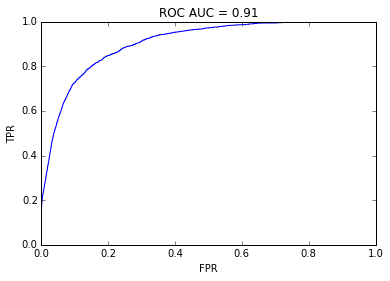

In [13]:
prob_mlp = tmva_mlp.predict_proba(data_test)

roc_auc = roc_auc_score(labels_test, prob_mlp[:, 1])
fpr, tpr, _ = roc_curve(labels_test, prob_mlp[:, 1])

plt.plot(fpr, tpr)
plt.title("ROC AUC = %.2f" % roc_auc)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig(work_path + "/roc_auc.pdf")
plt.show()

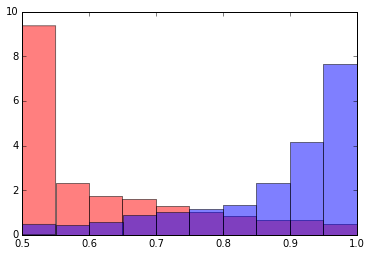

In [14]:
plt.hist(prob_mlp[labels_test==0, 1], color='r', normed=True, alpha=0.5)
plt.hist(prob_mlp[labels_test==1, 1], color='b', normed=True, alpha=0.5)
plt.show()

# Read eval data

In [6]:
filename = data_path + "/data_eval.csv"

n = sum(1 for line in open(filename)) - 1
s = n//10
skip = sorted(random.sample(xrange(1,n+1),n-s))

data_eval = pandas.read_csv(filename, skiprows=skip)

labels_eval = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.

# Evaluation

In [7]:
import os, sys
sys.path.append('src')

from get_figures import all_figures

In [8]:
params = {}
params['PARTICLE'] = particle
params['TRACK'] = track

proba_eval = tmva_mlp.predict_proba(data_eval)

In [10]:
%%time
all_figures(params, data_eval, proba_eval, labels_eval, features, path= work_path + "/pic")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 37.9 µs
